# 导入相关库

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

# 数据处理

In [2]:
# 加载波士顿房价数据
data = fetch_openml(name="boston", version=1, as_frame=True)
X = data.data
y = data.target

In [3]:
# 转成 numpy
X = X.to_numpy()
y = y.to_numpy().reshape(-1, 1)

# 数据标准化
scaler_X = StandardScaler()
scaler_y = StandardScaler()
X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y)


In [4]:
# 转为训练和测试集
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size=0.2, random_state=42)

In [5]:
# 转为 PyTorch Tensor
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)

In [6]:
# 从训练集进一步拆分出验证集（80% 训练 → 64% 训练 + 16% 验证）
X_train_final, X_val, y_train_final, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42
)


# 模型搭建

In [7]:
# 定义 MLP 模型
class MLP(nn.Module):
    def __init__(self, input_dim):
        super(MLP, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 1)
        )

    def forward(self, x):
        return self.model(x)

model = MLP(input_dim=13)

In [8]:
# 损失函数和优化器
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

/Users/kewuyu/miniconda3/envs/torch/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [9]:
epochs = 100
train_losses = []
val_losses = []

for epoch in range(epochs):
    # 训练阶段
    model.train()
    optimizer.zero_grad()
    outputs = model(X_train_final)
    loss = criterion(outputs, y_train_final)
    loss.backward()
    optimizer.step()
    train_losses.append(loss.item())

    # 验证阶段
    model.eval()
    with torch.no_grad():
        val_output = model(X_val)
        val_loss = criterion(val_output, y_val)
        val_losses.append(val_loss.item())

    # 打印信息
    if (epoch + 1) % 20 == 0:
        print(f"Epoch [{epoch+1}/{epochs}], Train Loss: {loss.item():.4f}, Val Loss: {val_loss.item():.4f}")


Epoch [20/100], Train Loss: 0.0992, Val Loss: 0.1871
Epoch [40/100], Train Loss: 0.0554, Val Loss: 0.1397
Epoch [60/100], Train Loss: 0.0407, Val Loss: 0.1282
Epoch [80/100], Train Loss: 0.0314, Val Loss: 0.1282
Epoch [100/100], Train Loss: 0.0239, Val Loss: 0.1289


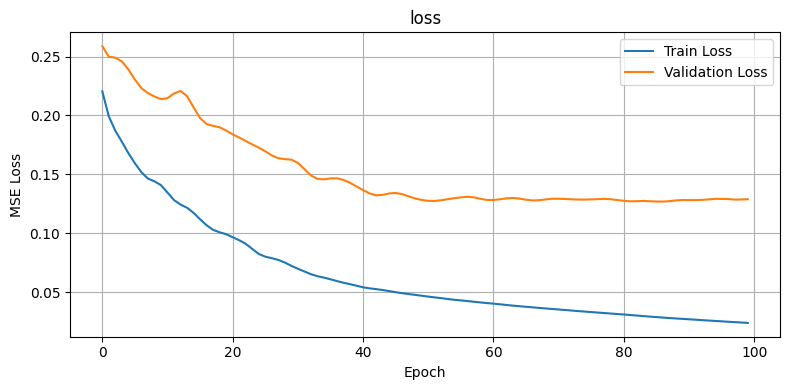

In [10]:
# 绘制训练 vs 验证损失曲线
plt.figure(figsize=(8, 4))
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.title("loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


# 模型推理验证

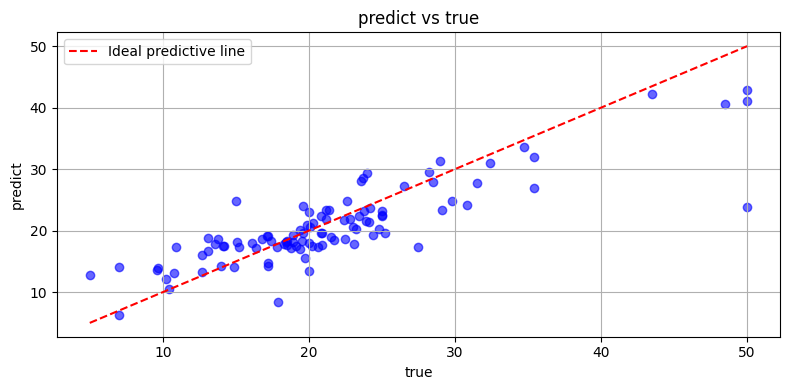

In [11]:
# 测试预测 vs 实际对比图
model.eval()
with torch.no_grad():
    predictions = model(X_test)
    y_pred_real = scaler_y.inverse_transform(predictions.numpy())
    y_true_real = scaler_y.inverse_transform(y_test.numpy())

# 可视化预测效果
plt.figure(figsize=(8, 4))
plt.scatter(y_true_real, y_pred_real, color='blue', alpha=0.6)
plt.plot([y_true_real.min(), y_true_real.max()],
         [y_true_real.min(), y_true_real.max()],
         color='red', linestyle='--', label='Ideal predictive line')
plt.xlabel("true")
plt.ylabel("predict")
plt.title("predict vs true")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
# 计算指标：R²、MAE、RMSE

r2 = r2_score(y_true_real, y_pred_real)
mae = mean_absolute_error(y_true_real, y_pred_real)
rmse = np.sqrt(mean_squared_error(y_true_real, y_pred_real))

print(f"\n模型评估指标：")
print(f"R² Score: {r2:.4f}")
print(f"MAE     : {mae:.4f}")
print(f"RMSE    : {rmse:.4f}")


模型评估指标：
R² Score: 0.7117
MAE     : 3.1903
RMSE    : 4.5983
